

---


# Plota mapa do ABI para um horário e o acumulado de chuva do merge e de raios para o dia 22/set/2025

---



- Faltou imagens das 16:30 às 18:10 h no dia 22/set/2025
- https://ftp.cptec.inpe.br/goes/goes19/goes19_web/ams_ret_ch13_baixa/2025/
- https://g1.globo.com/sp/sao-paulo/noticia/2025/09/22/rajadas-de-vento-chegam-a-quase-100-kmh-em-dia-de-estragos-causados-por-tempestade-na-grande-sp.ghtml
 - Realizado por: Enrique V. Mattos - 25/09/2025


---

# **1° Passo:** Preparando ambiente



In [1]:
# instala bibliotecas
!pip install -q ultraplot cartopy boto3 gdal salem rasterio pyproj geopandas descartes pygrib

# download dos arquivos auxiliares
!wget -c https://raw.githubusercontent.com/evmpython/imagens_GOES/main/input/utilities_goes19.py
!wget -c https://raw.githubusercontent.com/evmpython/imagens_GOES/main/input/ir.cpt

# importa bibliotecas
import xarray as xr                                              # Work with multidimensional arrays
import matplotlib.pyplot as plt                                  # Plotting library
from matplotlib import cm                                        # Colormap handling utilities
import cartopy, cartopy.crs as ccrs                              # Plot maps
import cartopy.io.shapereader as shpreader                       # Read shapefiles
from datetime import timedelta, datetime                         # Basic Dates and time types
from utilities_goes19 import download_CMI, download_GLM, remap, loadCPT # Our own utilities
import numpy as np                                               # Scientific computing with Python
import os                                                        # Miscellaneous operating system interfaces
import pandas as pd                                              # Work with dataframes
import geopandas as gpd                                          # Work with geodataframes
import salem                                                     # Work with shapefiles
import ultraplot as uplt
import pygrib
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import salem

# monta drive
from google.colab import drive
drive.mount('/content/drive')

# caminho do diretório
dir = '/content/drive/MyDrive/2-PESQUISA/0_GLM/estudos_de_caso/2025-09-22-FRENTEFRIA_RS_SUDESTE'

# Diretório de Saída
import os
dir_output = f'{dir}/output/abi_merge_raiodiario'
os.makedirs(dir_output, exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.7 MB/s eta 0:00:00
--2025-09-27 20:59:28--  https://raw.githubusercontent.com/evmpython/imagens_GOES/main/input/utilities_goes19.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 

# Imagem ABI



Remapping...
Remap finished! Time: 1.3 seconds


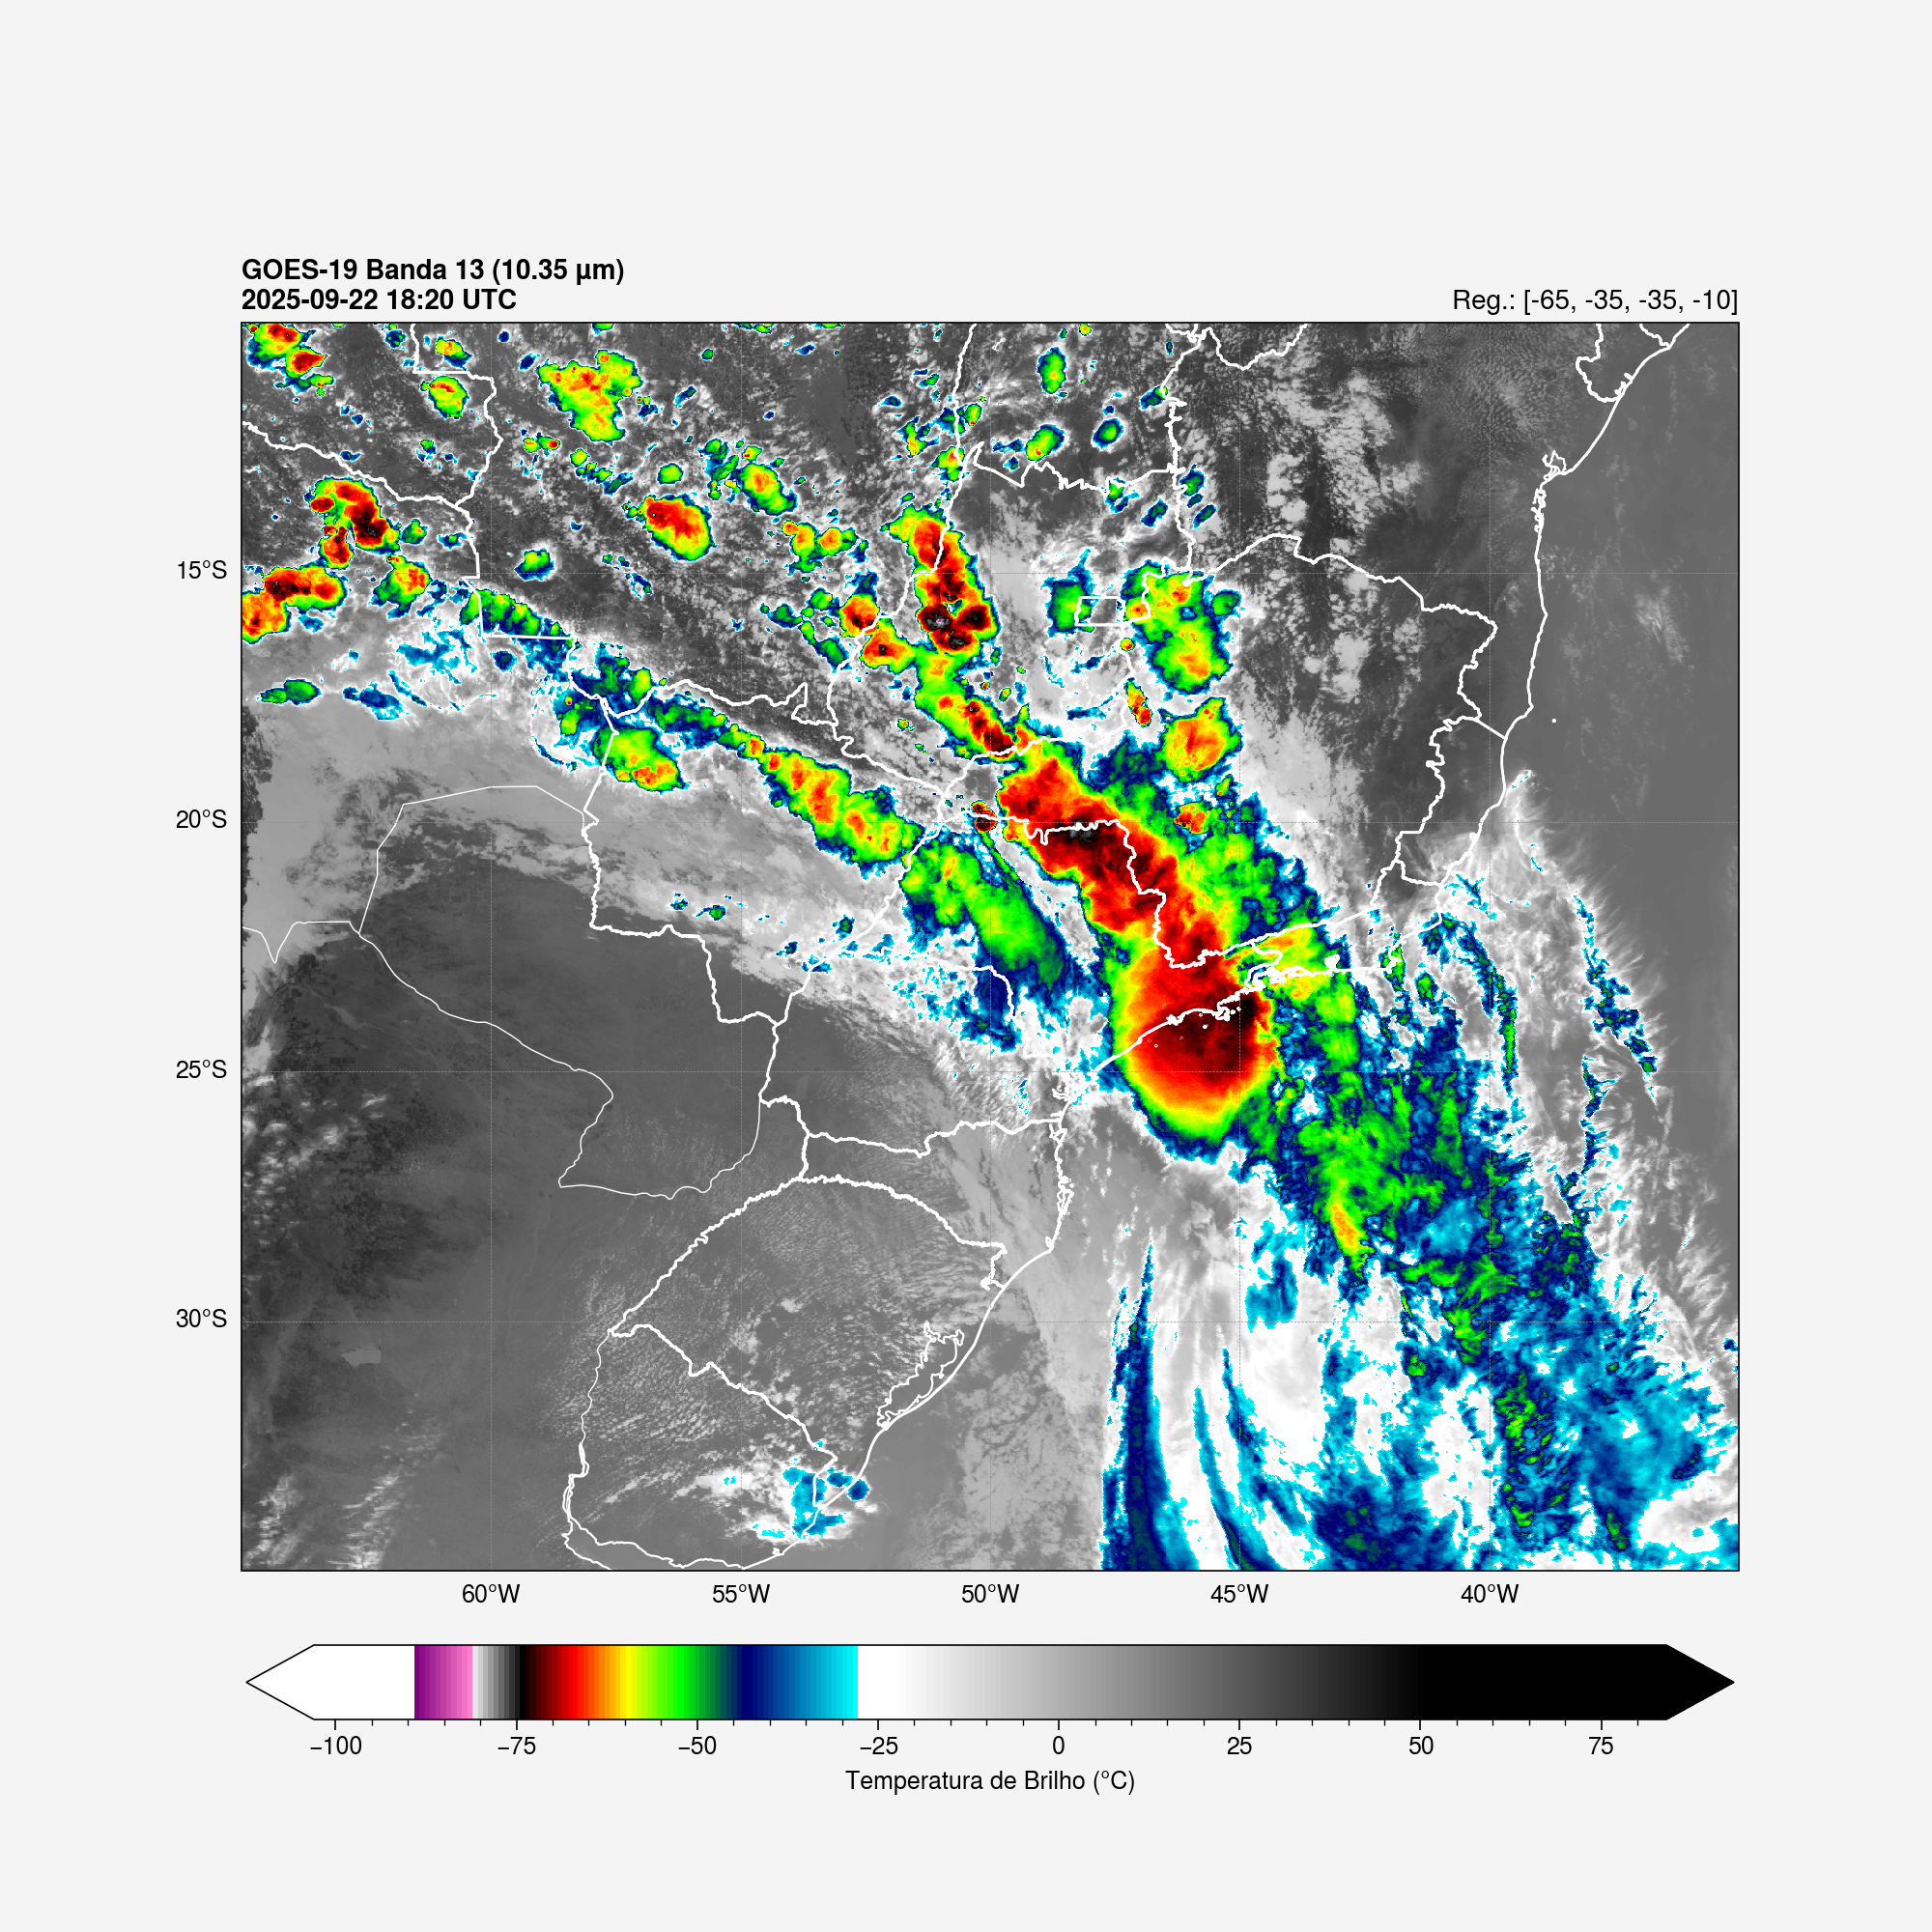

CPU times: user 12.4 s, sys: 693 ms, total: 13.1 s
Wall time: 22.1 s


In [2]:
%%time
#========================================================================================================================#
#                                               REQUIRED MODULES
#========================================================================================================================#
import xarray as xr                                              # Work with multidimensional arrays
import matplotlib.pyplot as plt                                  # Plotting library
from matplotlib import cm                                        # Colormap handling utilities
import cartopy, cartopy.crs as ccrs                              # Plot maps
import cartopy.io.shapereader as shpreader                       # Read shapefiles
from datetime import timedelta, datetime                         # Basic Dates and time types
from utilities_goes19 import download_CMI, download_GLM, remap, loadCPT # Our own utilities
import numpy as np                                               # Scientific computing with Python
import os                                                        # Miscellaneous operating system interfaces
import pandas as pd                                              # Work with dataframes
import geopandas as gpd                                          # Work with geodataframes
import salem                                                     # Work with shapefiles

#========================================================================================================================#
#                                        CRIA DIRETÓRIO DE ENTRADA E SAÍDA
#========================================================================================================================#
input = "/content/input"; os.makedirs(input, exist_ok=True)
output = f"{dir}/output"

#========================================================================================================================#
#                                               DOWNLOAD DO ARQUIVO
#========================================================================================================================#
# data de processamento
yyyymmddhhmn = '202509221820'

# canal do ABI
band = '13'

# download do arquivo (CMI: "Cloud and Moisture Imagery" Product)
file_name = download_CMI(yyyymmddhhmn, band, input)

# caminho do arquivo que foi baixado
path = f'{input}/{file_name}.nc'

#========================================================================================================================#
#                                         REPROJETA E FAZ A LEITURA DO ARQUIVO
#========================================================================================================================#
# área desejada (min lon, min lat, max lon, max lat)
lonmin, lonmax, latmin, latmax = -65, -35, -35, -10
extent = [lonmin, latmin, lonmax, latmax] # min lon, max lon, min lat, max lat

# chama a função que faz a reprojeção (file, variable, extent, resolution)
grid = remap(path, 'CMI', extent, 2)

# leitura do dado e transforma para °C
data = grid.ReadAsArray() - 273.15

#========================================================================================================================#
#                                                 PLOT THE IMAGE
#========================================================================================================================#
# tamanho da figura (largura x altura em polegadas)
plt.figure(figsize=(10,10))

# projeção geoestacionária do cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# define a extensão da imagem
img_extent = [extent[0], extent[2], extent[1], extent[3]] # Min lon, Max lon, Min lat, Max lat

# converte o arquivo CPT para ser usado em Python
cpt = loadCPT('ir.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt)

# plota imagem
img = ax.imshow(data, origin='upper', vmin=-103.0, vmax=84, extent=img_extent, cmap=colormap)

# linhas costeiras, bordas e linhas de grade do mapa
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# plota estados
shapefile = list(shpreader.Reader('https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/shapefiles/BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=1.0)

# barra de cores
plt.colorbar(img, label='Temperatura de Brilho (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# leitura da data/horário do arquivo NetCDF como uma string
date = (datetime.strptime(xr.open_dataset(path).time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')).strftime('%Y-%m-%d %H:%M UTC')

# título da figura
plt.title(f'GOES-19 Banda 13 (10.35 µm)\n{date}', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')

# salva figura
#plt.savefig(f'{output}/parte_4_{date.replace(" ", "_")}.jpg', bbox_inches='tight', dpi=300)

# mostra figura na tela
plt.show()

# ABI + MERGE + RAIOS POR DIA


File /content/input/OR_ABI-L2-CMIPF-M6C13_G19_s20252651820187_e20252651829507_c20252651829552.nc exists
Remapping...
Remap finished! Time: 0.84 seconds
--2025-09-27 21:00:51--  http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/09/MERGE_CPTEC_20250922.grib2
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.178.56
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/09/MERGE_CPTEC_20250922.grib2 [following]
--2025-09-27 21:00:52--  https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/09/MERGE_CPTEC_20250922.grib2
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416092 (406K)
Saving to: ‘MERGE_CPTEC_20250922.grib2’

MERGE_CPTEC_2025092 100%[===================>] 406.34K   716KB/s    in 0.6s    

2025-09-27 21:

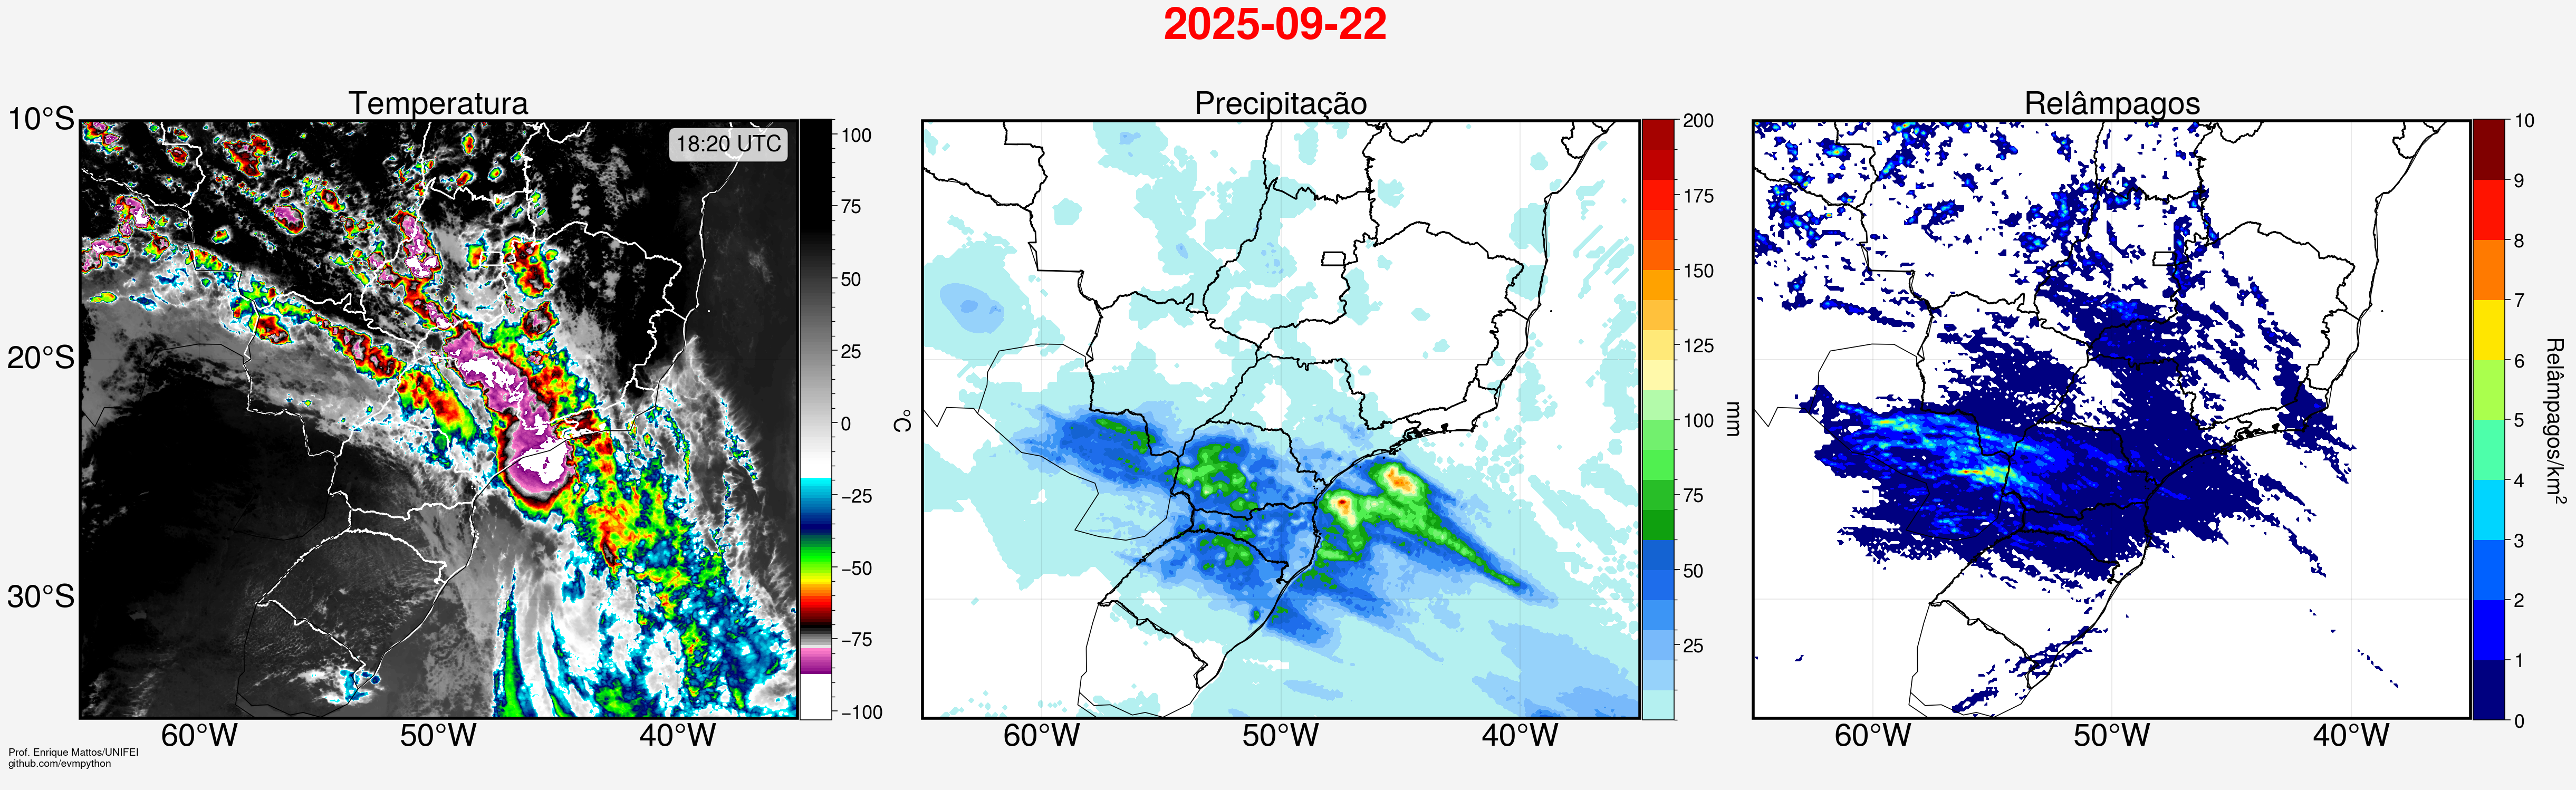

CPU times: user 1min 43s, sys: 969 ms, total: 1min 44s
Wall time: 2min


In [3]:
%%time
# cria moldura da figura
fig, ax = uplt.subplots(ncols=3, nrows=1, axheight=6.9, axwidth=6.8, tight=True, proj='pcarree')

# área desejada (min lon, min lat, max lon, max lat)
lonmin, lonmax, latmin, latmax = -65, -35, -35, -10

# formata os eixos
ax.format(coast=True, borders=True, innerborders=True,
          labels=True, latlines=10, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          abc=False, #abcstyle='(a)', abcsize=5
          small='30px', large='30px',
          linewidth=2,
          suptitle='2025-09-22', suptitlecolor='red', suptitlesize=30)

#========================================================================================================================#
#                                                  FIG-1: ABI
#========================================================================================================================#
# data de processamento
yyyymmddhhmn = '202509221820'

# canal do ABI
band = '13'

# download do arquivo (CMI: "Cloud and Moisture Imagery" Product)
file_name = download_CMI(yyyymmddhhmn, band, input)

# caminho do arquivo que foi baixado
path = f'{input}/{file_name}.nc'

# área desejada
lonmin, lonmax, latmin, latmax = -65, -35, -35, -10
extent = [lonmin, latmin, lonmax, latmax] # min lon, max lon, min lat, max lat

# chama a função que faz a reprojeção (file, variable, extent, resolution)
grid = remap(path, 'CMI', extent, 2)

# leitura do arquivo netcdf
ds_ret = xr.open_dataset(f'/content//input/{file_name}_ret.nc').sel(lon=slice(lonmin, lonmax), lat=slice(latmax, latmin))

# paleta de cores
cpt_ir = loadCPT(f'/content/ir.cpt')
cmap_ir = cm.colors.LinearSegmentedColormap('cpt_ir', cpt_ir)

# mapa
map1 = ax[0].contourf(ds_ret['lon'],
                      ds_ret['lat'],
                      (ds_ret['Band1']/10.) - 273.15,
                      cmap=cmap_ir,
                      levels=uplt.arange(-103.0, 105, 1.0))

# plota estados
shapefile = list(shpreader.Reader('https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/shapefiles/BR_UF_2019.shp').geometries())
ax[0].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=1.0)

# título
ax[0].format(title='Temperatura', labels=[True, False, True, False])
#ax[0].text(0.83, 0.95, '18:20 UTC', transform=ax[0].transAxes, color='white', fontsize=15)
ax[0].text(0.83, 0.95, '18:20 UTC', transform=ax[0].transAxes,
           color='black', fontsize=15,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# plota barra de cores da figura
ax[0].colorbar(map1, label='$\degree$C', ticks=25, ticklabelsize=13, labelsize=15, space=0.2, length=0.825, width=0.3)

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin-3.,latmin-2.), fontsize=7, color='black')

#========================================================================================================================#
#                                                  FIG-2: MERGE
#========================================================================================================================#
# define as 24 cores da paleta de PRECIPITAÇÃO
colors = ["#b4f0f0", "#96d2fa", "#78b9fa", "#3c95f5", "#1e6deb", "#1463d2", "#0fa00f",
          "#28be28", "#50f050", "#72f06e", "#b3faaa", "#fff9aa", "#ffe978", "#ffc13c",
          "#ffa200", "#ff6200", "#ff3300", "#ff1500", "#c00100", "#a50200", "#870000",
          "#653b32"]

# carrega a paleta de cores através do cmap
cmap = matplotlib.colors.ListedColormap(colors)

# seta a cor para valores acima do valor máximo
cmap.set_over('#000000')

# seta a cor para valores abaixo do valor mínimo
cmap.set_under('#aaaaaa')

# baixando arquivo diário de chuva
!wget http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/09/MERGE_CPTEC_20250922.grib2

# leitura do arquivo
grib = pygrib.open('/content/MERGE_CPTEC_20250922.grib2')
grb = grib.select(name='Precipitation')[0]
precip_dia, lats, lons = grb.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)

# mapa
map2 = ax[1].contourf(lons, lats, precip_dia, cmap=cmap, levels=uplt.arange(0.01, 200, 10))  #, extend='max')

# plota estados
shapefile = list(shpreader.Reader('https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/shapefiles/BR_UF_2019.shp').geometries())
ax[1].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1.0)

# título
ax[1].format(title='Precipitação', labels=[False, False, True, False])

# barra de cores
ax[1].colorbar(map2, label='mm', ticks=25, ticklabelsize=13, labelsize=15, space=0.2, length=0.825, width=0.3)

#========================================================================================================================#
#                                                FIG-3: RAIOS DIÁRIO
#========================================================================================================================#
# leitura do dado
ds_flash = xr.open_dataset(f'{dir}/output/glm_diario/flash_glm_goes19_2025-09-22.nc')

# remove valores zero convertendo para NaN (mantém estrutura do xarray)
ds_flash['flash'] = ds_flash['flash'].where(ds_flash['flash'] != 0, np.nan)

# mapa
map3 = ax[2].contourf(ds_flash['lon'],
                      ds_flash['lat'],
                      ds_flash['flash']/64.,
                      cmap='jet',
                      vmin=0., vmax=10,
                      levels=uplt.arange(0., 10, 1))

# plota estados
shapefile = list(shpreader.Reader('https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/shapefiles/BR_UF_2019.shp').geometries())
ax[2].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1.0)

# título
ax[2].format(title='Relâmpagos', labels=[False, False, True, False])

# barra de cores
ax[2].colorbar(map3, label='Relâmpagos/km$^{2}$', ticks=1, ticklabelsize=13, labelsize=15, space=0.2, length=0.825, width=0.3)
#========================================================================================================================#

# salva figura
fig.save(f'{dir_output}/abi_merge_raiosdiario_2025-09-22.jpg', bbox_inches='tight', dpi=300)

# exibe a figura na tela
uplt.show()

In [4]:
ds_ret

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 1250, lon: 1500)
Coordinates:
  * lat      (lat) float64 10kB -10.01 -10.03 -10.05 ... -34.95 -34.97 -34.99
  * lon      (lon) float64 12kB -64.99 -64.97 -64.95 ... -35.05 -35.03 -35.01
Data variables:
    Band1    (lat, lon) float32 8MB 2.039e+03 2.039e+03 ... 2.498e+03 2.478e+03
    crs      |S1 1B ...
Attributes: (12/32)
    Conventions:                    CF-1.5
    GDAL:                           GDAL 3.8.4, released 2024/02/08
    history:                        Sat Sep 27 21:00:22 2025: GDAL Create( /c...
    GDAL_cdm_data_type:             Image
    GDAL_Conventions:               CF-1.7
    GDAL_dataset_name:              OR_ABI-L2-CMIPF-M6C13_G19_s20252651820187...
    ...                             ...
    GDAL_standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    GDAL_summary:                   Single emissive band Cloud and Moisture I...
    GDAL_timeline_id:               ABI Mode 6
    GDAL_time_coverage_end:         2025-09-22T18:29:50.7Z
    GDAL_time_coverage_start:       2025-09-22T18:20:18.7Z
    GDAL_title:                     ABI L2 Cloud and Moisture Imagery

In [5]:
print(float(ds_ret['Band1'].min()))
print(float(ds_ret['Band1'].max()))

1567.0
3657.0


# Contabiliza os relâmpagos por Estado do Brasil.
Esta etapa demora 3min.

In [8]:
# lendo shapefile dos estados
go = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/GO/GO_UF_2019.shp')
mt = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/MT/MT_UF_2019.shp')
ms = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/MS/MS_UF_2019.shp')

mg = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/MG/MG_UF_2019.shp')
es = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/ES/ES_UF_2019.shp')
rj = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/RJ/RJ_UF_2019.shp')
sp = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp')

pr = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/PR/PR_UF_2019.shp')
sc = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/SC/SC_UF_2019.shp')
rs = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/RS/RS_UF_2019.shp')

In [9]:
# estraindo os flashes de cada estado
flash_go = int(ds_flash['flash'].salem.roi(shape=go).sum(('lat', 'lon')))
flash_mt = int(ds_flash['flash'].salem.roi(shape=mt).sum(('lat', 'lon')))
flash_ms = int(ds_flash['flash'].salem.roi(shape=ms).sum(('lat', 'lon')))

flash_mg = int(ds_flash['flash'].salem.roi(shape=mg).sum(('lat', 'lon')))
flash_es = int(ds_flash['flash'].salem.roi(shape=es).sum(('lat', 'lon')))
flash_rj = int(ds_flash['flash'].salem.roi(shape=rj).sum(('lat', 'lon')))
flash_sp = int(ds_flash['flash'].salem.roi(shape=sp).sum(('lat', 'lon')))

flash_pr = int(ds_flash['flash'].salem.roi(shape=pr).sum(('lat', 'lon')))
flash_sc = int(ds_flash['flash'].salem.roi(shape=sc).sum(('lat', 'lon')))
flash_rs = int(ds_flash['flash'].salem.roi(shape=rs).sum(('lat', 'lon')))

# organiza os dados
df = pd.DataFrame({'estado': ['GO', 'MT', 'MS', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC', 'RS'],
                   'flash': [flash_go, flash_mt, flash_ms, flash_mg, flash_es, flash_rj, flash_sp, flash_pr, flash_sc, flash_rs]})
df.sort_values(by='flash', inplace=True, ascending=False)
df

estado   flash
7     PR  150151
1     MT   84525
2     MS   54121
0     GO   50211
3     MG   39910
6     SP   37699
8     SC   33533
9     RS   19290
5     RJ    4401
4     ES       0